# Laboratorio 2 - Visión por computadora

- Nelson García
- Joaquín Puente 
- Diego Linares

## Task 1 - Notch Filter para eliminar ruido periódico

Eliminación de ruido sinusoidal (patrón de rayas diagonales) en imágenes satelitales usando filtrado en el dominio de frecuencia.

Imagen cargada: (512, 512)


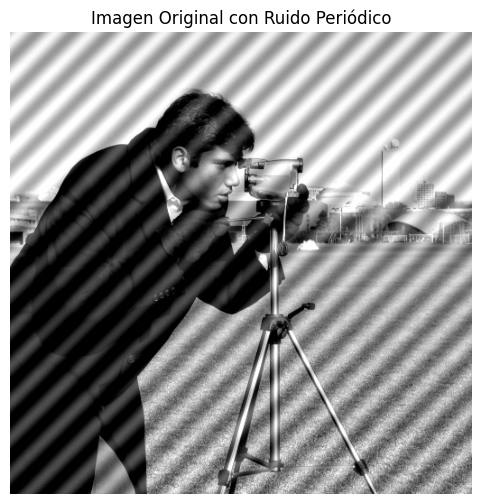

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imgs/periodic_noise.jpg", cv2.IMREAD_GRAYSCALE)
print(f"Imagen cargada: {img.shape}")
plt.figure(figsize=(8, 6))
plt.imshow(img, cmap='gray')
plt.title("Imagen Original con Ruido Periódico")
plt.axis('off')
plt.show()

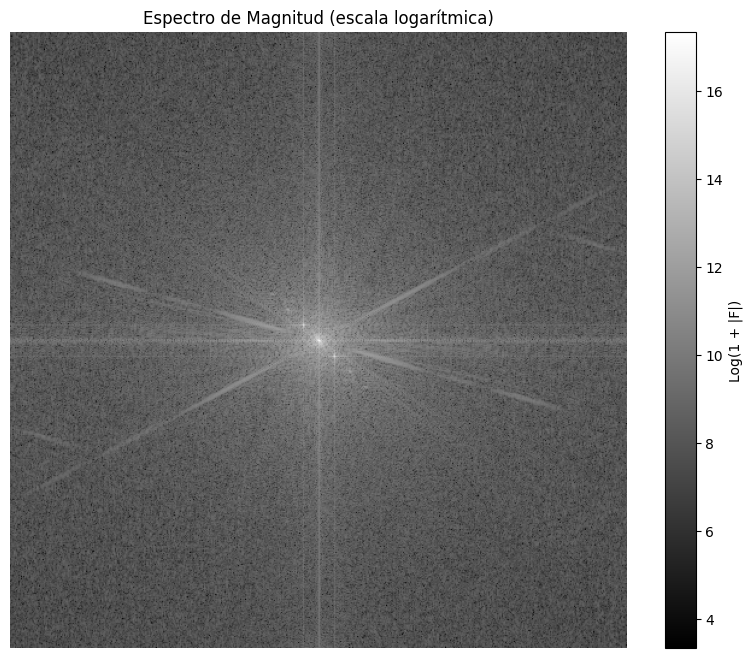

Las líneas brillantes que salen del centro representan las frecuencias del ruido periódico


In [ ]:
F = np.fft.fft2(img.astype(np.float32))
Fshift = np.fft.fftshift(F)

magnitude = np.log1p(np.abs(Fshift))

h, w = img.shape
cy, cx = h // 2, w // 2

yy, xx = np.mgrid[0:h, 0:w]
dist_from_center = np.sqrt((yy - cy)**2 + (xx - cx)**2)
angles_map = np.arctan2(yy - cy, xx - cx)

plt.figure(figsize=(10, 8))
plt.imshow(magnitude, cmap='gray')
plt.title("Espectro de Magnitud (escala logarítmica)")
plt.colorbar(label='Log(1 + |F|)')
plt.axis('off')
plt.show()

print("Las líneas brillantes que salen del centro representan las frecuencias del ruido periódico")

In [ ]:

from scipy.signal import find_peaks

DC_RADIUS = 3

n_angles = 360
angles_test = np.linspace(0, np.pi, n_angles, endpoint=False)
angular_profile = []

for angle in angles_test:
    angle_diff1 = np.abs(np.mod(angles_map - angle + np.pi, 2*np.pi) - np.pi)
    angle_diff2 = np.abs(np.mod(angles_map - (angle + np.pi) + np.pi, 2*np.pi) - np.pi)
    angle_mask = (np.minimum(angle_diff1, angle_diff2) < np.radians(1)) & (dist_from_center > DC_RADIUS)
    
    if np.any(angle_mask):
        angular_profile.append(np.sum(magnitude[angle_mask]))
    else:
        angular_profile.append(0)

angular_profile = np.array(angular_profile)

peaks_idx, _ = find_peaks(angular_profile, height=np.percentile(angular_profile, 80), distance=15)
dominant_angles_rad = angles_test[peaks_idx]
dominant_angles = np.degrees(dominant_angles_rad)

print(f"Ángulos de ruido detectados automáticamente: {[round(a) for a in dominant_angles]}°")

plt.figure(figsize=(12, 10))
plt.imshow(magnitude, cmap='gray')
plt.plot(cx, cy, 'g+', markersize=25, markeredgewidth=3, label='DC (centro)')

length = min(h, w) // 2 - 20
colors = ['r', 'orange', 'yellow', 'cyan']
for i, angle_deg in enumerate(dominant_angles):
    for offset in [0, 180]:
        angle_rad = np.radians(angle_deg + offset)
        x_end = cx + length * np.cos(angle_rad)
        y_end = cy + length * np.sin(angle_rad)
        plt.plot([cx, x_end], [cy, y_end], '--', color=colors[i % len(colors)], linewidth=2, alpha=0.7)

plt.title(f"Espectro con líneas de ruido detectadas: {[round(a) for a in dominant_angles]}°")
plt.legend(loc='upper right')
plt.axis('off')
plt.show()

Ángulos de ruido detectados automáticamente: [44, 134]°


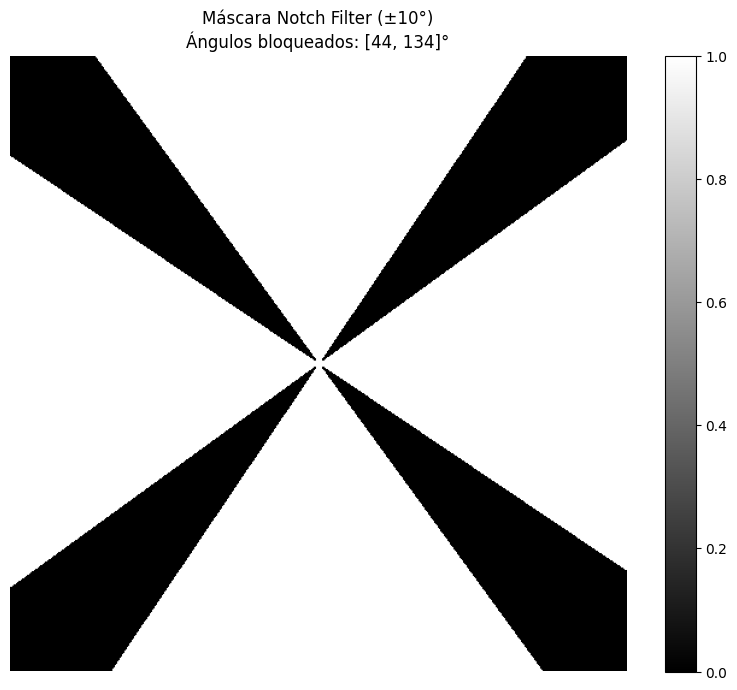

Ángulos bloqueados: [44, 134]°
Ancho de banda: ±10°
Radio DC preservado: 3 pixels


In [ ]:
notch_mask = np.ones((h, w), dtype=np.float32)
BAND_WIDTH = np.radians(10) 

for angle_rad in dominant_angles_rad:
    for angle_offset in [0, np.pi]:
        target_angle = angle_rad + angle_offset
        angle_diff = np.abs(np.mod(angles_map - target_angle + np.pi, 2*np.pi) - np.pi)
        band = (angle_diff < BAND_WIDTH) & (dist_from_center > DC_RADIUS)
        notch_mask[band] = 0

plt.figure(figsize=(10, 8))
plt.imshow(notch_mask, cmap='gray')
plt.title(f"Máscara Notch Filter (±{int(np.degrees(BAND_WIDTH))}°)\nÁngulos bloqueados: {[round(a) for a in dominant_angles]}°")
plt.colorbar()
plt.axis('off')
plt.show()

print(f"Ángulos bloqueados: {[round(a) for a in dominant_angles]}°")
print(f"Ancho de banda: ±{int(np.degrees(BAND_WIDTH))}°")
print(f"Radio DC preservado: {DC_RADIUS} pixels")

In [ ]:
Fshift_filtered = Fshift * notch_mask

F_ishift = np.fft.ifftshift(Fshift_filtered)
img_restored = np.fft.ifft2(F_ishift)
img_restored = np.real(img_restored)

img_restored = np.clip(img_restored, 0, 255).astype(np.uint8)

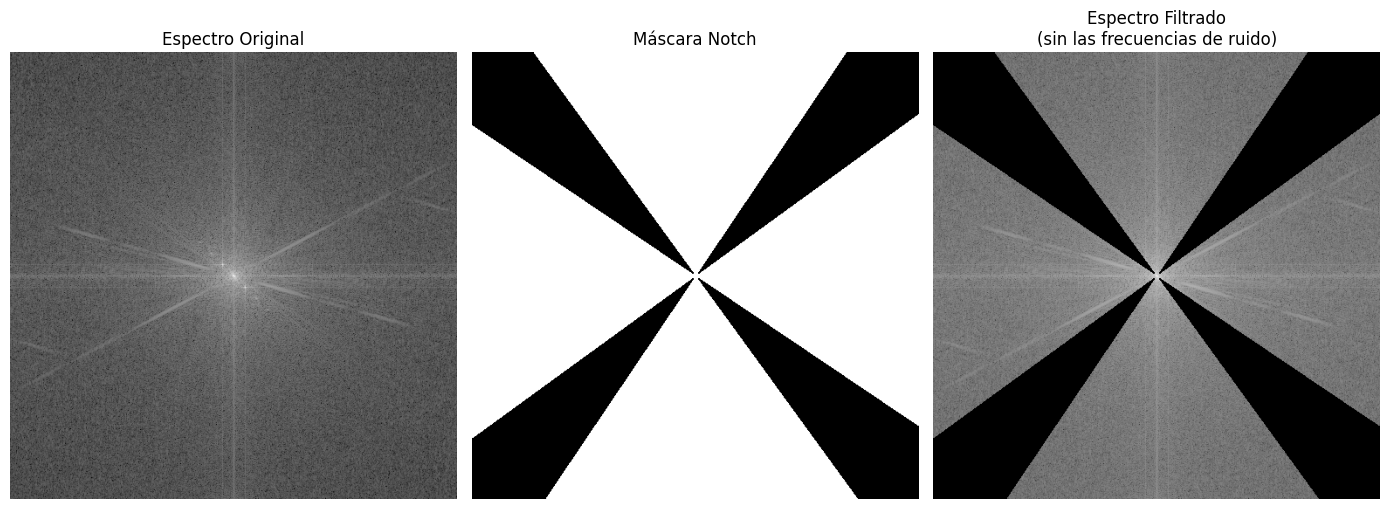

La imagen restaurada muestra los detalles sin las rayas diagonales del ruido


In [ ]:
magnitude_filtered = np.log1p(np.abs(Fshift_filtered))

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.imshow(magnitude, cmap='gray')
plt.title("Espectro Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(notch_mask, cmap='gray')
plt.title("Máscara Notch")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(magnitude_filtered, cmap='gray')
plt.title("Espectro Filtrado\n(sin las frecuencias de ruido)")
plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Imagen Original (con ruido periódico)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_restored, cmap='gray')
plt.title("Imagen Restaurada (después del Notch Filter)")
plt.axis('off')

plt.tight_layout()
plt.show()

### ¿Por qué un filtro de promedio 5x5 sería una mala solución?

Un filtro de promedio (average filter) de 5x5 en el dominio espacial sería una mala solución para este problema específico porque el filtro de promedio actúa como un filtro pasa-bajos que suaviza toda la imagen, eliminando tanto el ruido como los detalles geográficos importantes (bordes, texturas naturales, estructuras pequeñas).Además, no es selectivo en frecuencia, el ruido periódico tiene frecuencias muy específicas (los picos que identificamos en el espectro). Un filtro espacial 5x5 no puede distinguir entre estas frecuencias parásitas y las frecuencias similares que pertenecen a la información real de la imagen.

In [ ]:
kernel_avg = np.ones((5, 5), np.float32) / 25
img_avg_filtered = cv2.filter2D(img, -1, kernel_avg)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original (con ruido)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_avg_filtered, cmap='gray')
plt.title("Filtro Promedio 5x5\n(borroso, ruido aún visible)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_restored, cmap='gray')
plt.title("Notch Filter\n(nítido, sin ruido)")
plt.axis('off')

plt.tight_layout()
plt.show()

## TASK 2

Está desarrollando un sistema biométrico de seguridad. El sensor de huellas dactilares está sucio y
produce imágenes binarias con dos tipos de defectos:
1. Pequeños puntos blancos en los valles negros de la huella (Ruido Sal)
2. Las “crestas” de la huella tienen pequeñas roturas que impiden que el algoritmo de matching
funcione (grietas).

In [341]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imgs/fingerprint_noisy.png", cv2.IMREAD_GRAYSCALE)

In [342]:
# que sea binaria
_, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

#  Apertura
kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
img_open = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_open)

# Cierre
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
img_final = cv2.morphologyEx(img_open, cv2.MORPH_CLOSE, kernel_close)


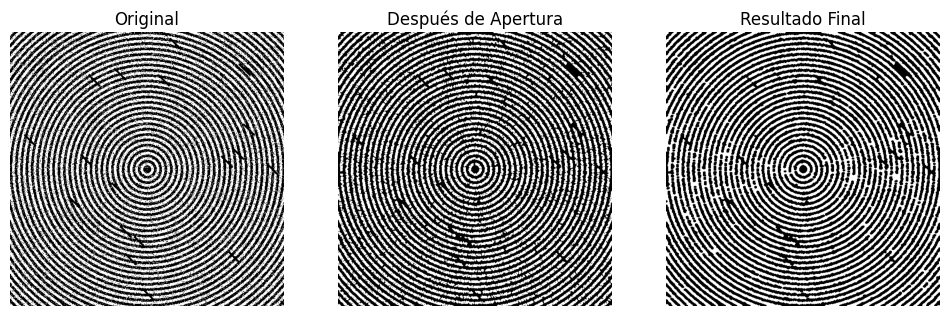

In [343]:

# Visualización
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_bin, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_open, cmap='gray')
plt.title("Después de Apertura")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_final, cmap='gray')
plt.title("Resultado Final")
plt.axis("off")

plt.show()

#### ¿El orden de los factores altera el producto?

Si se aplica Cierre luego Apertura: el cierre engorda el ruido blanco luego la apertura no logra eliminarlo lo que nos daria como resultado crestas más gruesas, ruido todavía presente

Demostración visual (orden incorrecto)

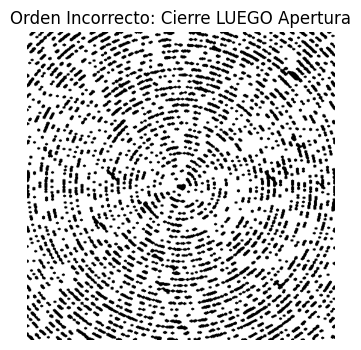

In [344]:
# Orden inverso (incorrecto)
img_close_first = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel_close)
img_wrong = cv2.morphologyEx(img_close_first, cv2.MORPH_OPEN, kernel_open)

plt.figure(figsize=(6,4))
plt.imshow(img_wrong, cmap='gray')
plt.title("Orden Incorrecto: Cierre LUEGO Apertura")
plt.axis("off")
plt.show()


El orden importa porque cada operación modifica el dominio sobre el que actúa la siguiente.
Primero hay que eliminar ruido pequeño, luego reparar estructuras grandes. Hacerlo al revés amplifica el problema.

## Task 3 

Una fábrica textil necesita detectar rasgaduras en telas de mezclilla (denim) automáticamente. El problema
es que la tela tiene una textura natural fuerte (patrón repetitivo) que confunde a los detectores de bordes
simples (Canny), detectando el tejido como si fuera un defecto. Por ello se le pide que usted diseñe un
pipeline híbrido que combine Fourier y Morfología para aislar solamente la rasgadura. Para ello comienza
por probar su solución en una imagen que tiene a mano. Con esto en mente, realice:

In [345]:
# Importar librerías:

import argparse
import numpy as np
import cv2
import matplotlib.pyplot as plt

1. Utilice Fourier para analizar la textura repetitiva de la tela. Diseñe un filtro que elimine las
frecuencias altas/repetitivas del tejido, dejando una imagen "suavizada" donde solo resalte la
anomalía (la rasgadura) y la iluminación global. (Supresión de Textura)
a. Hint: ¿Qué pasa si eliminamos las frecuencias altas periféricas o específicas?

In [346]:
IMG_NAME = "imgs/textile_defect.jpg"

In [347]:
LOWPASS_SIGMA = 35       # más alto = más suavizado (menos textura)
NOTCH_PEAKS = 8          # cuántos picos de textura apagar
NOTCH_RADIUS = 10        # tamaño del "agujero" alrededor del pico


In [348]:
# --- Cargar imagen en gris ---
img = cv2.imread(IMG_NAME, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"No pude leer {IMG_NAME}. ¿Está en el mismo folder?")

h, w = img.shape
cy, cx = h // 2, w // 2

In [349]:
# --- FFT (pasar a frecuencia) ---
F = np.fft.fft2(img.astype(np.float32))
Fshift = np.fft.fftshift(F)

In [350]:
print(Fshift)

[[-46818.         +0.j      -15542.334  -14124.787j
   -1315.128   +2560.6072j  ...  16163.516  -12359.44j
   -1315.128   -2560.6072j  -15542.334  +14124.787j  ]
 [-42763.934  +45745.11j    -20754.08   +24393.75j
   27225.318  -28475.424j   ... -29745.432  -27209.166j
  -46741.977  -17339.371j     -308.83356  -997.44867j]
 [  7145.835  -11420.683j    -1509.8965 -15950.877j
   15764.856  +48837.18j    ... -24121.773  +14740.924j
  -23631.668   +8009.361j   -23949.033   -7855.8438j ]
 ...
 [-25969.887   -3371.182j     9763.761  +11495.742j
   19612.19    -2855.056j   ... -37194.16    +3082.2898j
    5075.513  +24110.418j   -58052.992  +10967.885j  ]
 [  7145.835  +11420.683j   -23949.033   +7855.8438j
  -23631.668   -8009.361j   ...  17084.309   +8092.7744j
   15764.856  -48837.18j     -1509.8965 +15950.877j  ]
 [-42763.934  -45745.11j      -308.83356  +997.44867j
  -46741.977  +17339.371j   ... -16692.252  +41374.4j
   27225.318  +28475.424j   -20754.08   -24393.75j   ]]


In [351]:
# Magnitud (para visualizar el espectro y encontrar picos)
mag = np.log1p(np.abs(Fshift))

In [352]:
# --- Filtro 1: Low-pass gaussiano (quita altas frecuencias periféricas) ---
yy, xx = np.mgrid[0:h, 0:w]
dist2 = (yy - cy) ** 2 + (xx - cx) ** 2
lowpass = np.exp(-dist2 / (2.0 * (LOWPASS_SIGMA ** 2))).astype(np.float32)

# --- Filtro 2: Notch (apaga picos fuertes repetitivos del tejido) ---
mag2 = mag.copy()

In [353]:
# Quitar la zona central para no escoger "iluminación global" como pico
center_block = 25
mag2[cy - center_block:cy + center_block, cx - center_block:cx + center_block] = 0


In [354]:
# Elegir los picos más fuertes (aprox. patrones repetitivos)
flat = mag2.ravel()
idxs = np.argpartition(flat, -NOTCH_PEAKS)[-NOTCH_PEAKS:]
coords = np.column_stack(np.unravel_index(idxs, mag2.shape))


In [355]:
notch = np.ones((h, w), dtype=np.float32)
for y, x in coords:
    # Apaga un disco alrededor del pico y su simétrico (porque FFT de imagen real es simétrica)
    cv2.circle(notch, (int(x), int(y)), NOTCH_RADIUS, 0, -1)
    y2, x2 = int(2 * cy - y), int(2 * cx - x)
    if 0 <= y2 < h and 0 <= x2 < w:
        cv2.circle(notch, (x2, y2), NOTCH_RADIUS, 0, -1)

In [356]:
# --- Máscara final en frecuencia ---
freq_mask = lowpass * notch

# --- Aplicar filtro en frecuencia ---
F_filt = Fshift * freq_mask

# --- IFFT (volver al dominio espacial) ---
img_back = np.fft.ifft2(np.fft.ifftshift(F_filt))
img_back = np.real(img_back)

# Normalizar para visualizar bien
smooth = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

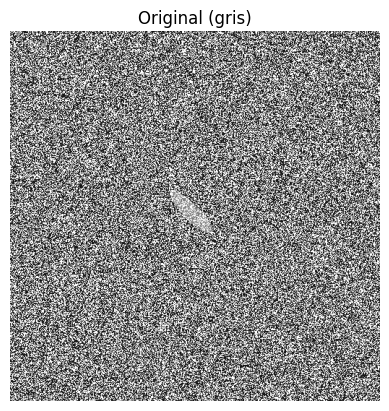

In [357]:
# --- Mostrar etapas ---
plt.figure()
plt.title("Original (gris)")
plt.imshow(img, cmap="gray")
plt.axis("off")



(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

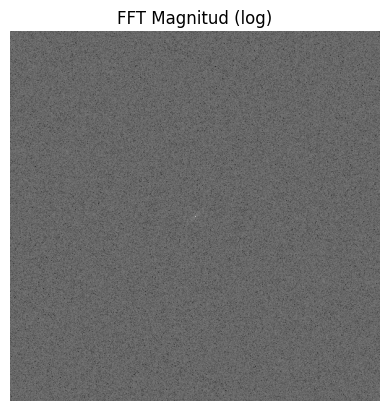

In [358]:
plt.figure()
plt.title("FFT Magnitud (log)")
plt.imshow(mag, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

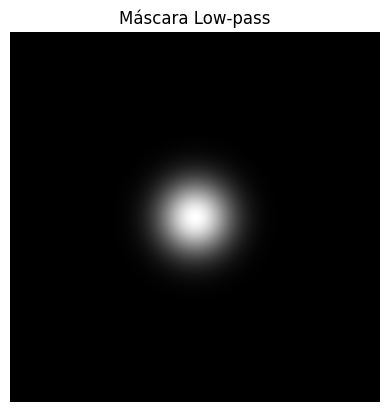

In [359]:
plt.figure()
plt.title("Máscara Low-pass")
plt.imshow(lowpass, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

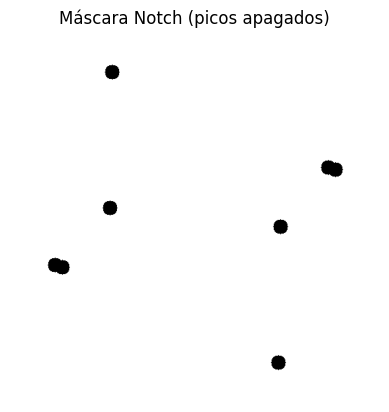

In [360]:
plt.figure()
plt.title("Máscara Notch (picos apagados)")
plt.imshow(notch, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

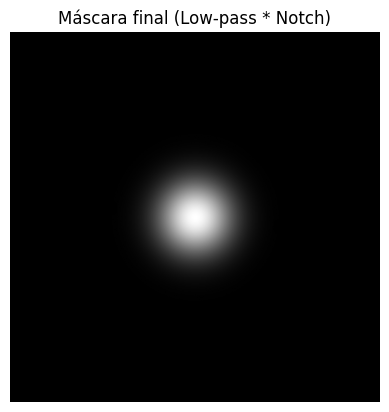

In [361]:
plt.figure()
plt.title("Máscara final (Low-pass * Notch)")
plt.imshow(freq_mask, cmap="gray")
plt.axis("off")


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

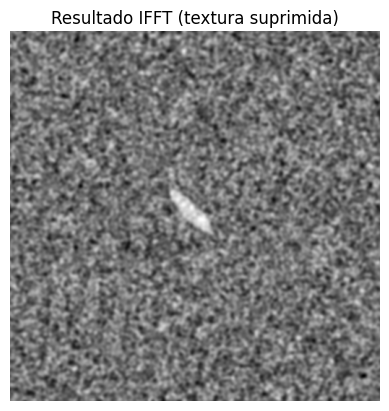

In [362]:
plt.figure()
plt.title("Resultado IFFT (textura suprimida)")
plt.imshow(smooth, cmap="gray")
plt.axis("off")

In [363]:
plt.show()

# Puntos Extras por Kahoot de la semana:

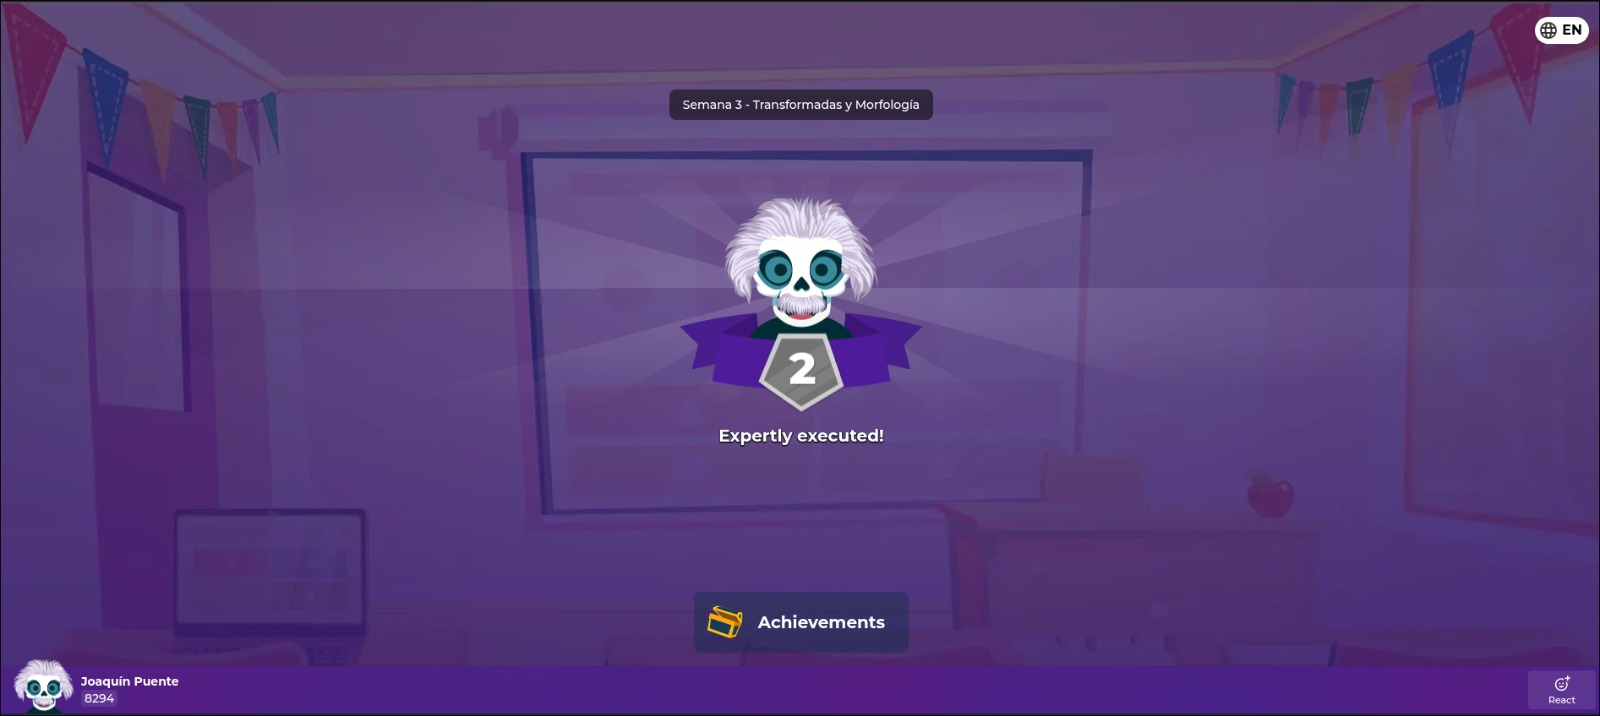



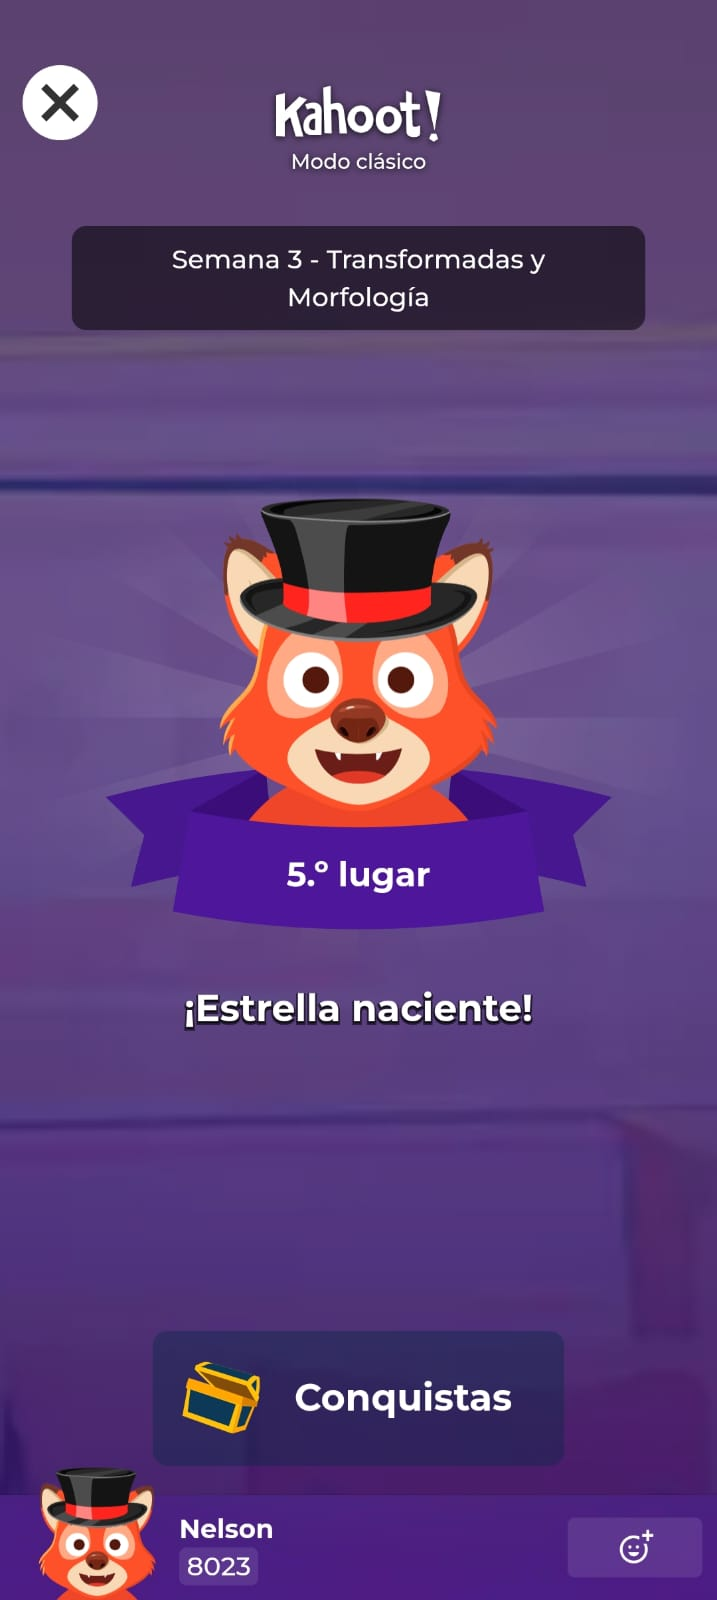